## Contact Codes

Trying to predict the likelihood of enrollment based solely on previous contacts with the college.
These contacts include things such as: 
* campus visits
* meeting at a college fair
* talking with a recruiter at their high school

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('fivethirtyeight') 

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, '../src/visualization/')
import visualize as vis

Load Contact Codes Data Sets and the Application Data Set.

The Contact Codes Data Set was altered such that all date-like attributes are recorded solely by the total days since 0 A.D.  Both files are included in the analysis.

Fields of Interest:
* Admission_application_date
* Admission_date
* Enrolled?
* Unique_student_ID

In [35]:
codes_dates = pd.read_csv('../data/processed/Qry_Contacts_xtab.csv')
codes_days = pd.read_csv('../data/processed/Qry_Contacts_xtab_days.csv')

df = pd.read_csv(
    '../data/processed/CriticalPath_Data_EM_Confidential_lessNoise.csv').drop(columns='Unnamed: 0')[[
    "Unique_student_ID","Enrolled","Admission_application_date","WeightatAcpt","TotalWeight"
]]

df['Admission_application_date'] = pd.to_datetime(df['Admission_application_date'])

months_to_days = {
1:0,
2:31,
3:59,
4:90,
5:120,
6:151,
7:181,
8:212,
9:243,
10:273,
11:304,
12:334
}


df['Admission_application_date_asDays'] = df['Admission_application_date'].dt.day + df['Admission_application_date'].dt.month.map(months_to_days) + df['Admission_application_date'].dt.year*365

Take only the students that are in the `CriticalPath_Data` file.

In [36]:
codes_days = codes_days.where(
    df.Unique_student_ID.isin(codes_days.Unique_student_ID)).dropna(subset=['Unique_student_ID'])

Merge the files together such that whether or not a student enrolls is linkable to all of the contact codes.

In [37]:
data = pd.merge(codes_days,df,how='left',on="Unique_student_ID")

for col in codes_days.columns.values:
    if col!='Unique_student_ID':
        data[col] = data[col][data[col] < data['Admission_application_date_asDays']]

## Create a shadow matrix of the data.

In [38]:
shadow_matrix = ~data.isna().drop(columns=["Unique_student_ID","Admission_application_date","Enrolled","WeightatAcpt","Admission_application_date_asDays","TotalWeight"]).astype(int)+2

Ned had previously said that the contact code weights in the WeightAtAccpt column were determined by the first letter of the contact code.

Therefore, take the sum of interactions for each letter, and use these columns in place of the original contact codes.

In [39]:
for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
    filter_col = [col for col in shadow_matrix if col.startswith(letter)]
    if len(filter_col)>0:
        shadow_matrix[letter] = shadow_matrix[filter_col].T.sum().T
        shadow_matrix = shadow_matrix.drop(columns=filter_col)

Some contact codes do not even appear and should be discounted.  Only look at the fields with greater than 1000 students with interactions.

In [40]:
shadow_matrix = shadow_matrix[shadow_matrix.columns[shadow_matrix[shadow_matrix>0].count()>1000]]

## PCA

In [41]:
# scaling the data before PCA
from sklearn.preprocessing import scale
scaled = pd.DataFrame(scale(shadow_matrix),columns=shadow_matrix.columns.values)

In [42]:
# implementing PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=6).fit(scaled)
pca_samples = pca.transform(scaled)

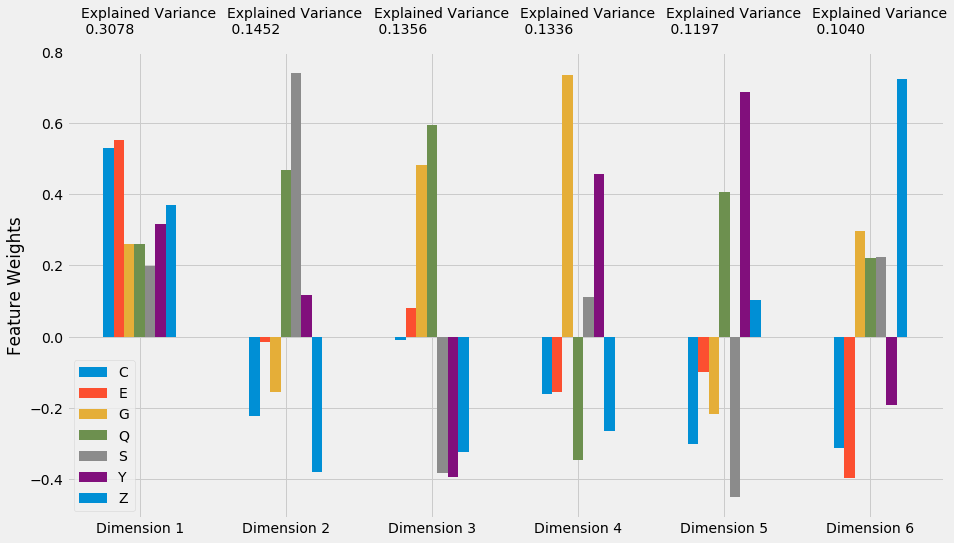

In [43]:
def pca_results(scaled, pca):
    
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = scaled.keys()) 
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights") 
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios# 
    for i, ev in enumerate(pca.explained_variance_ratio_): 
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

pca_results = pca_results(scaled, pca)

In [44]:
pca_results.cumsum()

,Explained Variance,C,E,G,Q,S,Y,Z
Dimension 1,0.3078,0.5303,0.5537,0.2611,0.2599,0.1995,0.3164,0.3696
Dimension 2,0.4530,0.3087,0.5394,0.1070,0.7281,0.9404,0.4332,-0.0114
Dimension 3,0.5886,0.2996,0.6212,0.5889,1.3233,0.5586,0.0387,-0.3360
Dimension 4,0.7222,0.1386,0.4661,1.3235,0.9780,0.6705,0.4957,-0.6002
Dimension 5,0.8419,-0.1620,0.3665,1.1059,1.3857,0.2199,1.1832,-0.4980
Dimension 6,0.9459,-0.4756,-0.0291,1.4023,1.6054,0.4432,0.9912,0.2247


## Scree Plot

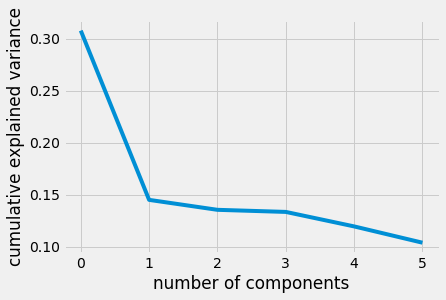

In [45]:
#Explained variance
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

# Biplot 

In [46]:
# creating a biplot

pca = PCA(n_components=2).fit(scaled)
reduced_data = pca.transform(scaled)
pca_samples = pca.transform(scaled)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

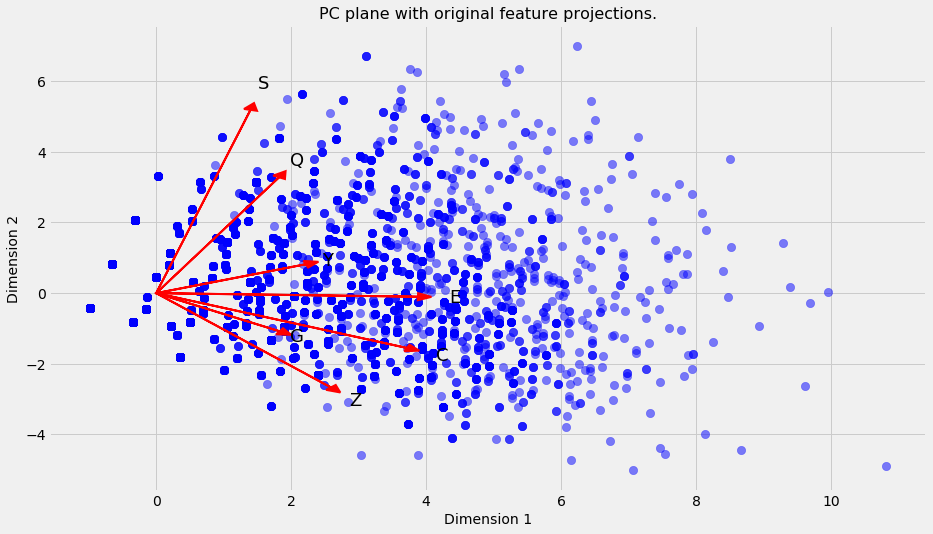

In [47]:
def biplot(shadow_matrix, reduced_data, pca):
    
    fig, ax = plt.subplots(figsize = (14,8))
    
    # scatterplot of the reduced data 
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # using scaling factors to make the arrows
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, shadow_matrix.columns[i], color='black', ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

biplot(shadow_matrix, reduced_data, pca);

### Linear Regression: Target of WeightAtAcpt

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
y = data['WeightatAcpt']
X = shadow_matrix[~y.isna()]
y = y[~y.isna()]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [49]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

The Mean Absolute Percentage Error is: 12.98 percent


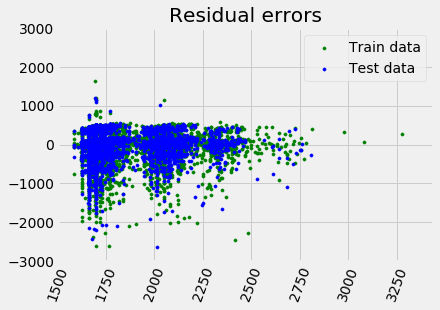

In [50]:
reg = vis.residual_error(X_train, X_test, y_train, y_test)
plt.ylim(-3000,3000);
plt.xlim(1500);
plt.xticks(rotation=70);

MAPE = 1/len(y) * abs(y-reg.predict(X.values))/y

print("The Mean Absolute Percentage Error is: %.2f percent" % (MAPE.sum()*100))

# Feature Importance

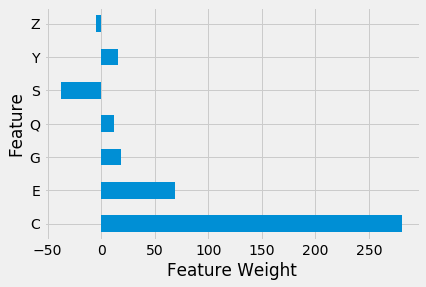

In [51]:
feature_importance = pd.Series(reg.coef_)
feature_importance.index = shadow_matrix.columns.values

feature_importance.plot(kind='barh');
plt.xlabel("Feature Weight")
plt.ylabel("Feature");